In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import yaml

In [3]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [4]:
from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [5]:
from scripts.generate_stats_v1 import plot_stats

In [6]:
%load_ext autoreload

## Simulation for Yield

In [7]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [8]:
%%writefile config/yield_v1.yml

# time unit: minute

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 5256000 #525600
    initial_cash: 0.5
    initial_bond: 0.8243606353500641

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'yield-v1'
      params:
        
  other-protocol:
    type: 'CIR'
    params:
        a: 5
        b: 0.06
        sigma: 0.05
        r0: 0.05

  arbitrageur:
    strategy: 'naive-arbitrageur'
    params:
      estimate_func: 'yield'
      
        
  tracking:
    dir: 'data/tracking-v11/yield_v1'


Overwriting config/yield_v1.yml


In [9]:
with open('config/yield_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|███████████████████████████████████████████████████████████████████████| 525500/525500 [00:28<00:00, 18645.27it/s]


Total_burn: 0

Saving tracking data to data/tracking-v11/yield_v1

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x800 with 0 Axes>

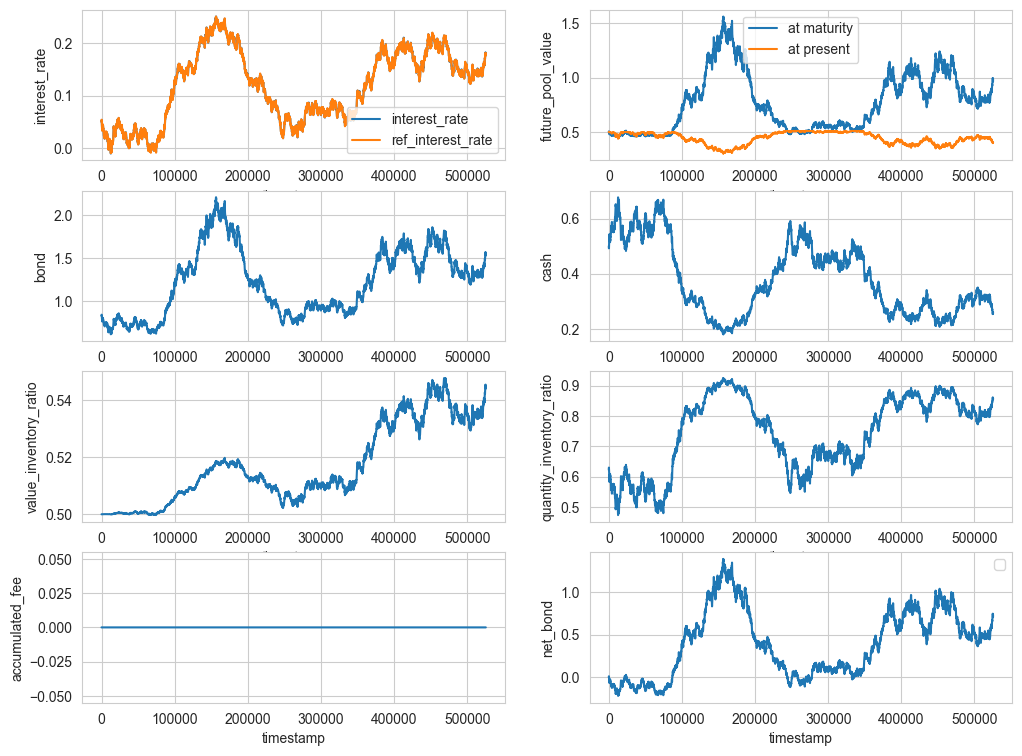

In [10]:
from scripts.generate_stats_v1 import plot_stats

fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking-v11/yield_v1', 'ALL_INFORMATION.json', fig_size=(12, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x1600 with 0 Axes>

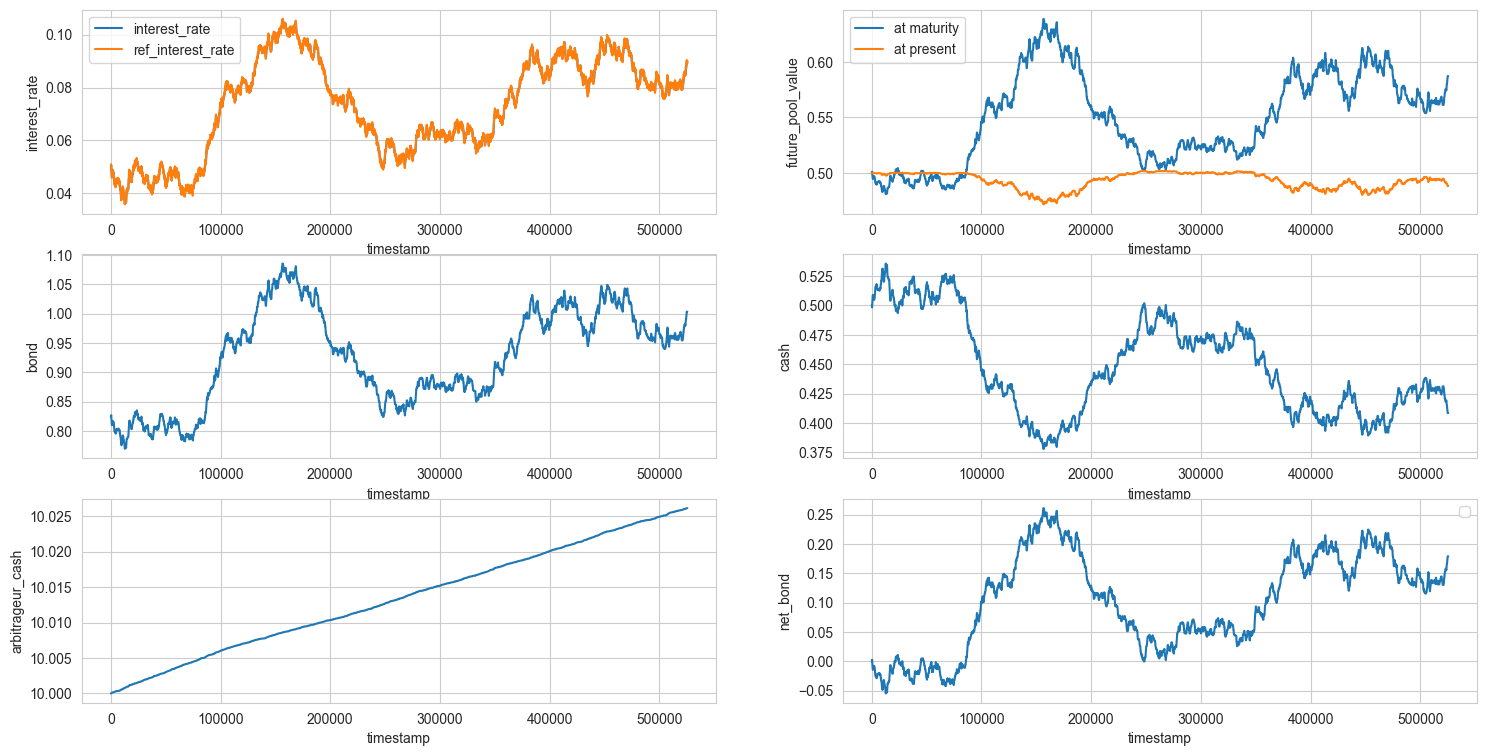

In [11]:
%autoreload 2

from scripts.generate_stats_v2 import plot_stats

fig = plt.figure(figsize=(10, 16))

plot_stats('data/tracking-v11/yield_v1', 'ALL_INFORMATION.json', fig_size=(18, 9))

## Proposed logit

$p = \frac{X_0}{X_0 + y_0}$

$r = \kappa logit(p) + r^{\star}$

$\alpha = \frac{1}{1 + \tau\kappa}$ 

$B^\star = e^{-r^\star \tau}$

$X_0 = x_0B^\star$

$X_{1}^{\alpha} + y_{1}^{\alpha} = X_{0}^{\alpha} + y_{0}^{\alpha}$

$x_1 = X_{1}B^\star$

In [12]:
_user_defined_func_path = "scripts/price_functions/price_v1.py"

In [13]:
%%writefile {_user_defined_func_path}

import numpy as np
from scipy.special import logit


def calculate_price(x, y, dx, dy, time_to_maturity, maturity_length, r_star, kappa) -> float:
    tau = time_to_maturity

    alpha = 1 / (1 + tau * kappa)
    Br = np.exp(-r_star * tau) 
    
    C = (x * Br) ** alpha + y ** alpha

    if dx != 0:
        new_x = x + dx
        new_y = (C - (Br * new_x) ** alpha) ** (1 / alpha)
        dy = new_y - y
    elif dy != 0:
        new_y = y + dy
        new_x = (C - new_y ** alpha) ** (1 / alpha) / Br
        dx = new_x - x

    if abs((x * Br) ** alpha + y ** alpha - ((x + dx) * Br) ** alpha - (y + dy) ** alpha) > 0.00001:
        raise Exception('Something wrong with ODE!')
    
    r0 = r_star * alpha + kappa * alpha * np.log(x / y)
    if abs(logit(x * np.exp(-r0 * tau) / (x * np.exp(-r0 * tau) + y)) * kappa + r_star - r0) > 0.00001:
        raise Exception('R0 not match!')

    if dx == 0 and dy == 0:
        dy = -np.exp(-tau * r0)
        dx = 1

    price = abs(dy / dx)

    return price

Overwriting scripts/price_functions/price_v1.py


In [14]:
%%writefile config/user_defined_v1.yml


version_name: 'v1'

config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 5256000
    initial_cash: 0.5
    initial_bond: 0.8243606353500641
    bond_burning: 1

  fee:
    rate: .000

  pricing_config:
      pricing_method: 'user-defined'
      params:
        price_function: 'scripts/price_functions/price_v1.py'
        kappa: 0.02
        r_star: 0.05
            
  other-protocol:
    type: 'CIR'
    params:
        a: 5
        b: 0.06
        sigma: 0.05
        r0: 0.05

  arbitrageur:
    strategy: 'naive-arbitrageur'
    params:
      estimate_func: 'polybond'
      kappa: 0.02
      r_star: 0.05

#   trader:
#     trade_data: 'sources/input/actor_trade/single_trade2.csv'

  tracking:
    dir: 'data/tracking-v11/v1.1'

Overwriting config/user_defined_v1.yml


In [15]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [16]:
with open('config/user_defined_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:35<00:00, 5503.84it/s]


Total_burn: -0.09683506671391104

Saving tracking data to data/tracking-v11/v1.1

------------------ Done simulation ------------------


In [17]:
%autoreload 2

from scripts.generate_stats_v1 import plot_stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x1600 with 0 Axes>

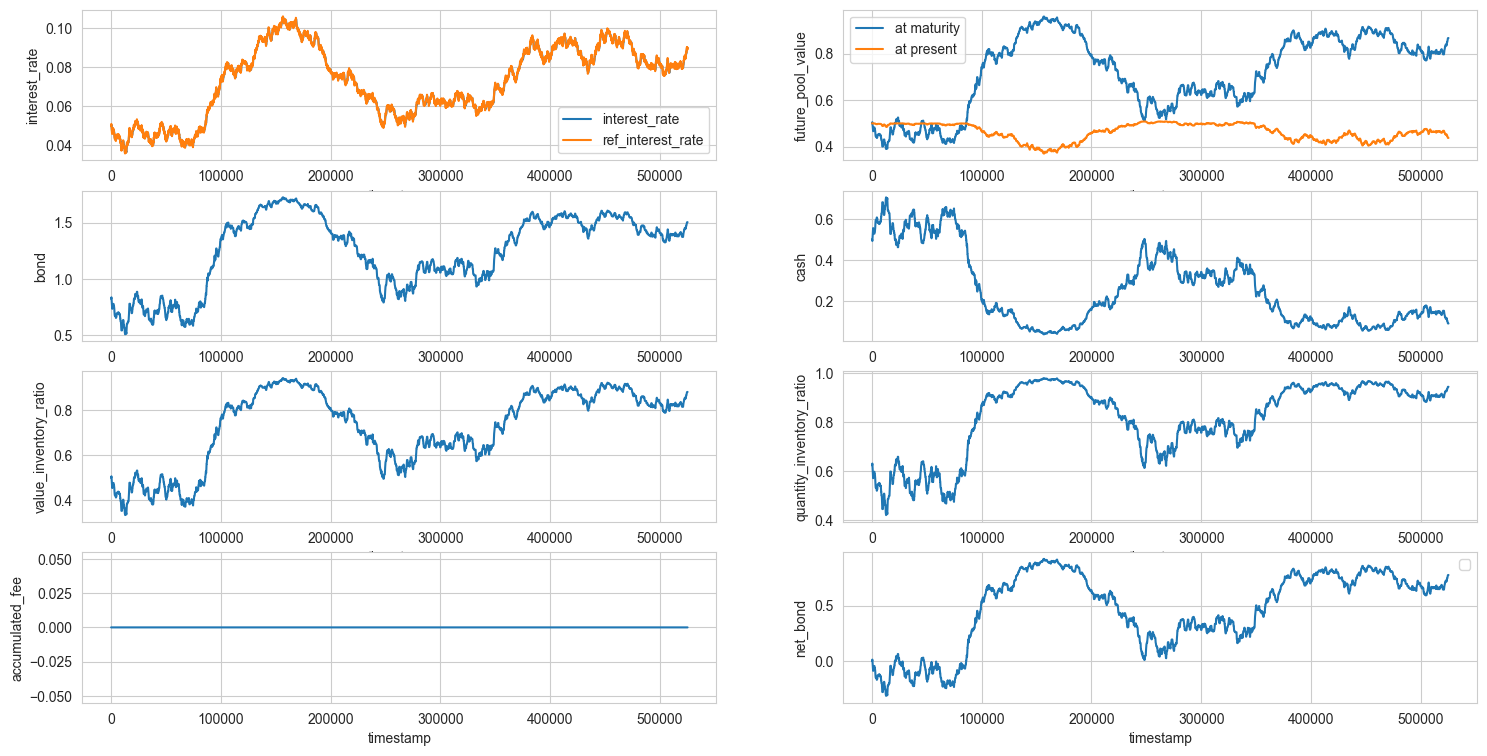

In [18]:
fig = plt.figure(figsize=(10, 16))

plot_stats('data/tracking-v11/v1.1', 'ALL_INFORMATION.json', fig_size=(18, 9))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x1600 with 0 Axes>

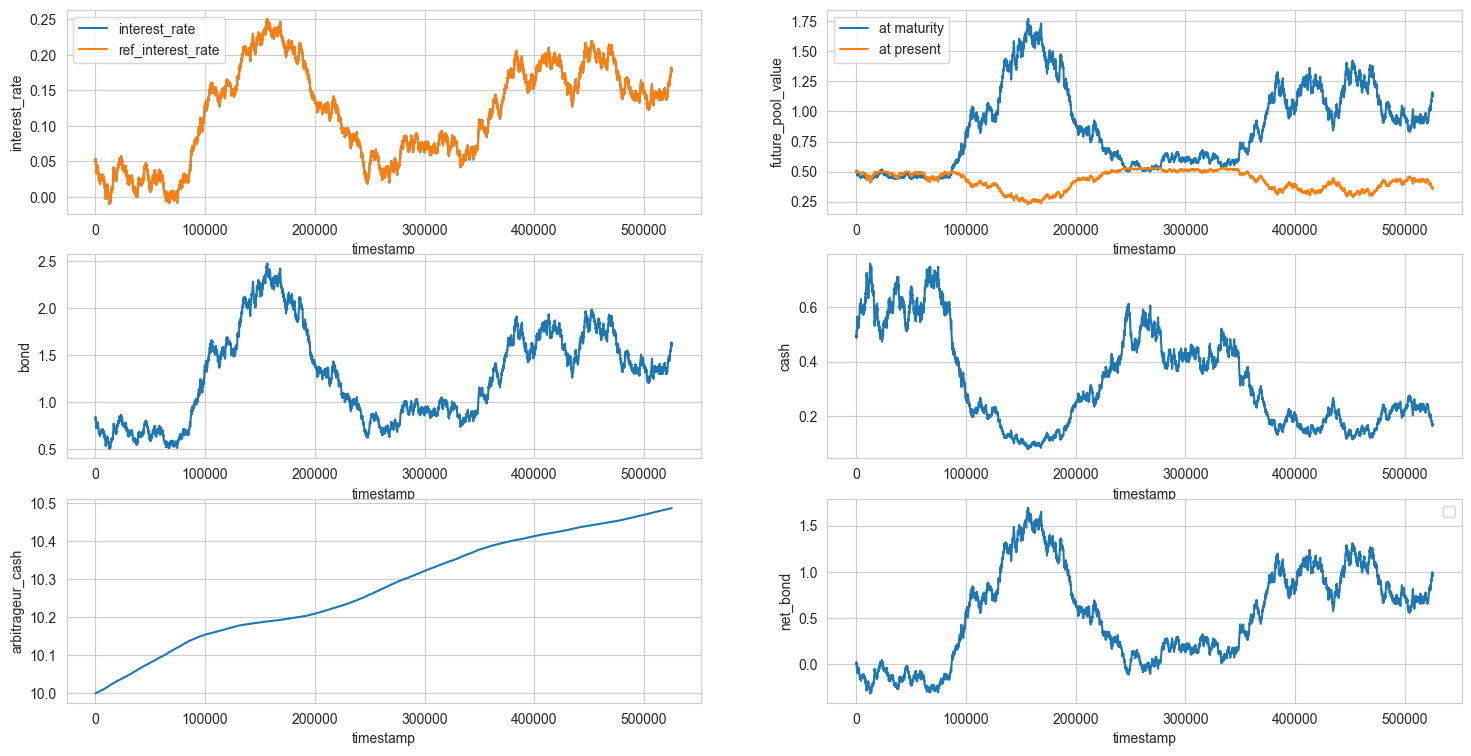

In [19]:
%autoreload 2

from scripts.generate_stats_v2 import plot_stats

fig = plt.figure(figsize=(10, 16))

plot_stats('data/tracking-v11/v1.1', 'ALL_INFORMATION.json', fig_size=(18, 9))

## Notional Finance

In [20]:
%%writefile config/logit_notional_v3.yml

version_name: 'linear-notional-v1'

# time unit: minute
    
config:
  simulation:
    simulation_length: 525500
    begin_trade_time: 0
    maturity: 5256000
    initial_cash: 0.5
    initial_bond: 0.5

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'logit-notional-v3'
      params:
        kappa: 0.02
        r_star: 0.05
            
  other-protocol:
    type: 'CIR'
    params:
        a: 5
        b: 0.06
        sigma: 0.05
        r0: 0.05

  arbitrageur:
    strategy: 'naive-arbitrageur'
    params:
      estimate_func: 'notional'
      kappa: 0.02
      r_star: 0.05

#   trader:
#     trade_data: 'sources/input/actor_trade/single_trade2.csv'

  tracking:
    dir: 'data/tracking-v11/notional-v3'

Overwriting config/logit_notional_v3.yml


In [21]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [22]:
with open('config/logit_notional_v3.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 525500/525500 [01:01<00:00, 8559.09it/s]


Total_burn: 0

Saving tracking data to data/tracking-v11/notional-v3

------------------ Done simulation ------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x1600 with 0 Axes>

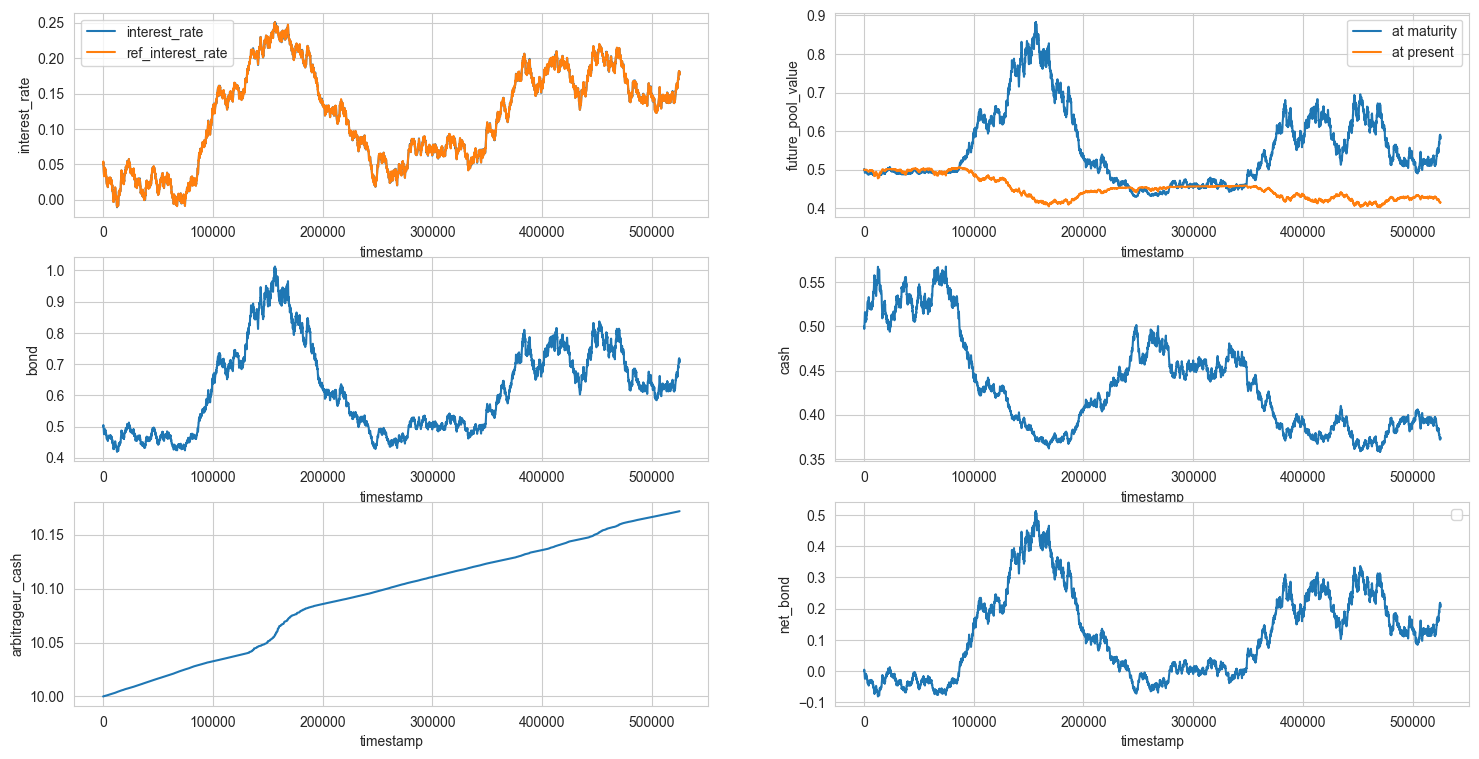

In [23]:
%autoreload 2

from scripts.generate_stats_v2 import plot_stats

fig = plt.figure(figsize=(10, 16))

plot_stats('data/tracking/notional-v3/', 'ALL_INFORMATION.json', fig_size=(18, 9))

In [18]:
import json


def read_data(folder_dir, file_path):
    file_path = os.path.join(folder_dir, file_path)

    with open(file_path, 'r') as file:
        data = json.load(file)

    _df = pd.DataFrame(data['value'])
    _df['timestamp'] = data['timestamp']
    _df['pool_address'] = data['pool_address']

    return _df

In [19]:
df = read_data('data/tracking/notional-v2/', 'ALL_INFORMATION.json')

In [20]:
df

,cash,bond,net_bond,time_to_maturity,interest_rate,accumulated_fee,last_price,timestamp,pool_address
0,0.500000,0.525636,-0.000000,5255999,0.051000,0.0,NaN,1,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
1,0.532172,0.472943,-0.052688,5255899,0.047640,0.0,0.620298,101,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
2,0.547187,0.448952,-0.076675,5255799,0.046042,0.0,0.630418,201,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
3,0.564292,0.422089,-0.103533,5255699,0.044193,0.0,0.642014,301,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
4,0.565633,0.420002,-0.105618,5255599,0.044046,0.0,0.643339,401,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
...,...,...,...,...,...,...,...,...,...
5250,0.143949,1.162131,0.676496,4730999,0.091771,0.0,0.438672,525001,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
5251,0.154063,1.139191,0.653574,4730899,0.090014,0.0,0.445449,525101,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
5252,0.153819,1.139720,0.654123,4730799,0.090055,0.0,0.445014,525201,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
5253,0.178060,1.086142,0.600563,4730699,0.086165,0.0,0.461227,525301,0xlbvpccssxnilxacvbfxrrjxogggzxo1699115315
